In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer


data = pd.read_csv("/content/Weather Data.csv")

print(data.head())


print(data.isnull().sum())


       Date/Time  Temp_C  Dew Point Temp_C  Rel Hum_%  Wind Speed_km/h  \
0  1/1/2012 0:00    -1.8              -3.9         86                4   
1  1/1/2012 1:00    -1.8              -3.7         87                4   
2  1/1/2012 2:00    -1.8              -3.4         89                7   
3  1/1/2012 3:00    -1.5              -3.2         88                6   
4  1/1/2012 4:00    -1.5              -3.3         88                7   

   Visibility_km  Press_kPa               Weather  
0            8.0     101.24                   Fog  
1            8.0     101.24                   Fog  
2            4.0     101.26  Freezing Drizzle,Fog  
3            4.0     101.27  Freezing Drizzle,Fog  
4            4.8     101.23                   Fog  
Date/Time           0
Temp_C              0
Dew Point Temp_C    0
Rel Hum_%           0
Wind Speed_km/h     0
Visibility_km       0
Press_kPa           0
Weather             0
dtype: int64


In [61]:
data.dropna(inplace=True)

data["Date"] = pd.to_datetime(data["Date/Time"])


In [62]:
data["year"] = data["Date"].dt.year
data["month"] = data["Date"].dt.month
data["day"] = data["Date"].dt.day
data["temp_humidity_interaction"] = data["Temp_C"] * data["Rel Hum_%"]
data["temp_diff"] = data["Temp_C"].diff()
data["temp_avg_3"] = data["Temp_C"].rolling(window=3).mean()

data["temp_humidity_interaction"] = data["Temp_C"] * data["Rel Hum_%"]


In [33]:

X = data.drop(columns=["Temp_C", "Date"])
y = data["Temp_C"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

y_train = pd.to_numeric(y_train, errors='coerce')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
models = {
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "LinearRegression": LinearRegression()
}
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"{name} R2 Score:", r2_score(y_test, y_pred))

RandomForest R2 Score: 0.9992269515083896
GradientBoosting R2 Score: 0.999266253649667
LinearRegression R2 Score: 0.999161745414075


In [63]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

param_dist = {
    "n_estimators": [50, 100],
    "max_depth": [10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=5,
                                   cv=3,
                                   scoring="r2",
                                   n_jobs=-1)

random_search.fit(X_train_scaled, y_train)
print("Best Parameters:", random_search.best_params_)
model = random_search.best_estimator_


Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


In [64]:
y_pred = model.predict(X_test_scaled)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Absolute Error: 0.21691867848208204
Mean Squared Error: 0.12556766634419883
R2 Score: 0.9991329618010633


In [65]:
prophet_data = data[["Date", "Temp_C"]].rename(columns={"Date": "ds", "Temp_C": "y"})

prophet_model = Prophet()
prophet_model.fit(prophet_data)

future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpay1n19n0/lwy_sf62.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpay1n19n0/kon2xn62.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23438', 'data', 'file=/tmp/tmpay1n19n0/lwy_sf62.json', 'init=/tmp/tmpay1n19n0/kon2xn62.json', 'output', 'file=/tmp/tmpay1n19n0/prophet_model1ko0fzr9/prophet_model-20250308000649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:06:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:06:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


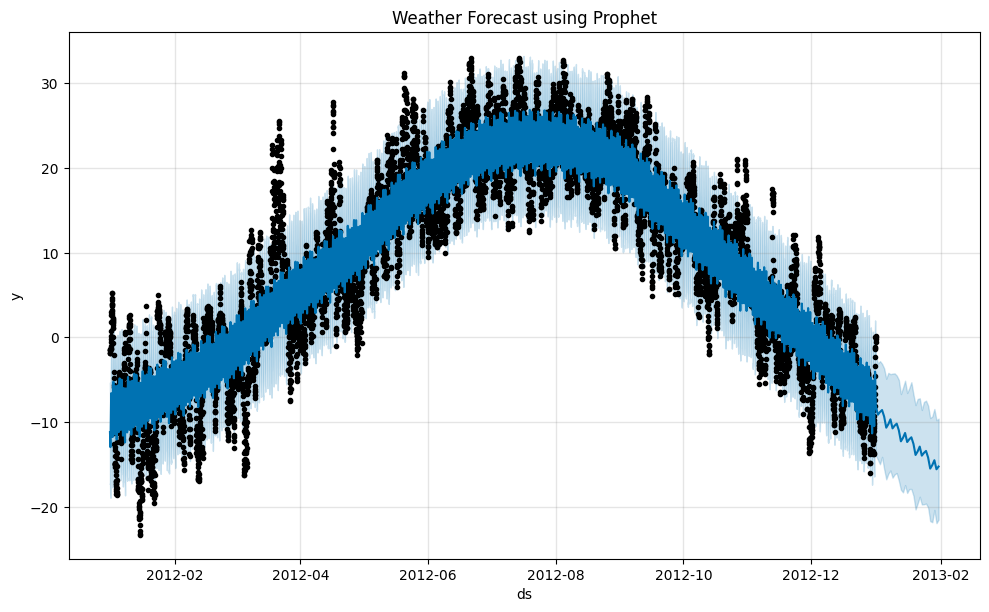

In [66]:
prophet_model.plot(forecast)
plt.title("Weather Forecast using Prophet")
plt.show()

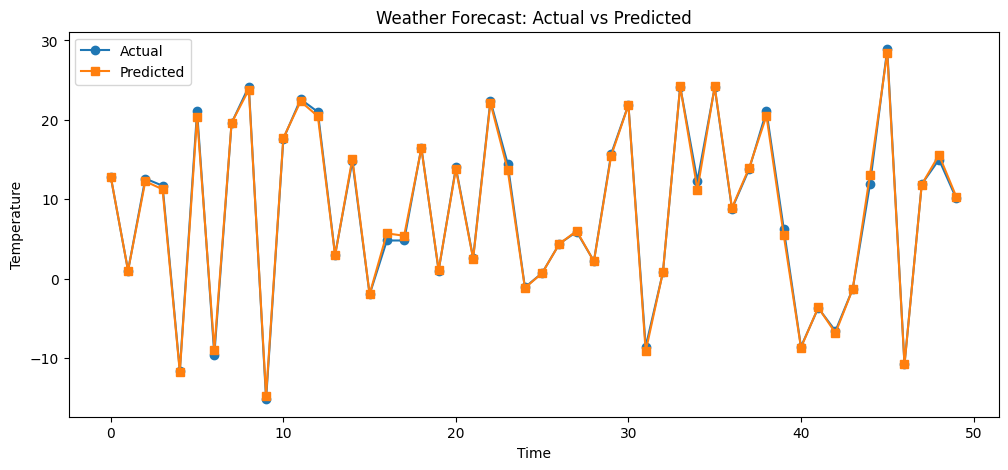

In [54]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:50], label="Actual", marker="o")
plt.plot(y_pred[:50], label="Predicted", marker="s")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Weather Forecast: Actual vs Predicted")
plt.legend()
plt.show()


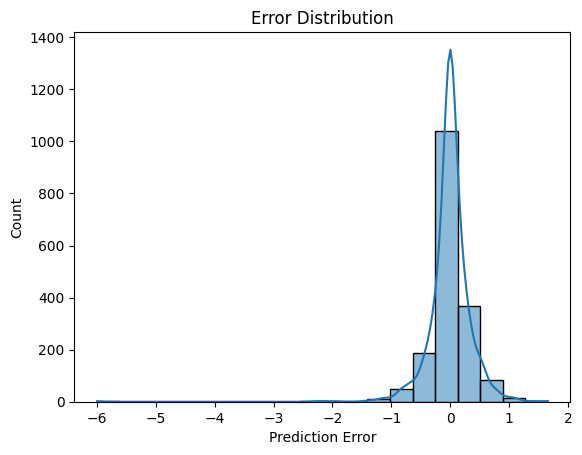

In [53]:
sns.histplot(y_test - y_pred, bins=20, kde=True)
plt.xlabel("Prediction Error")
plt.title("Error Distribution")
plt.show()

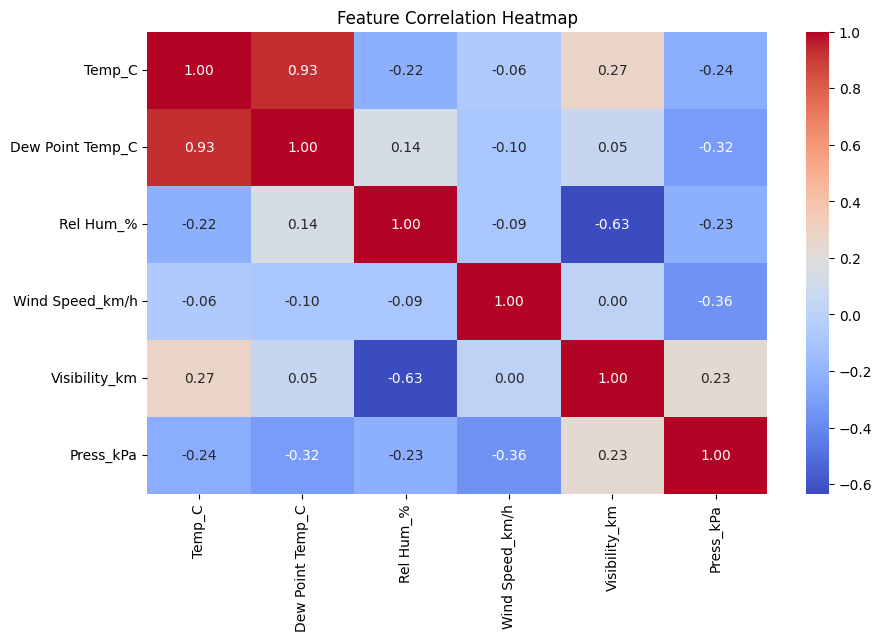

In [56]:
numerical_data = data.select_dtypes(include=np.number)

plt.figure(figsize=(10, 6))
sns.heatmap(numerical_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

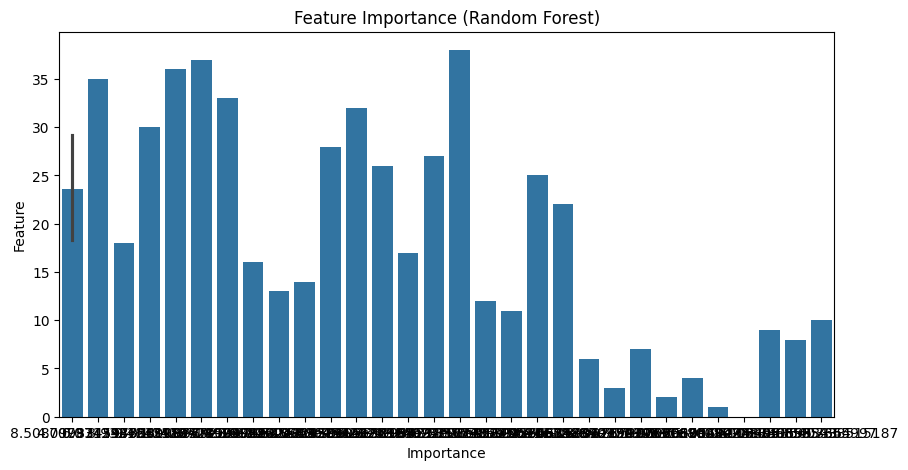

In [79]:
X_train_df = pd.DataFrame(X_train)
importances = model.feature_importances_
feature_names = X_train_df.columns

plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=feature_names)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Random Forest)")
plt.show()

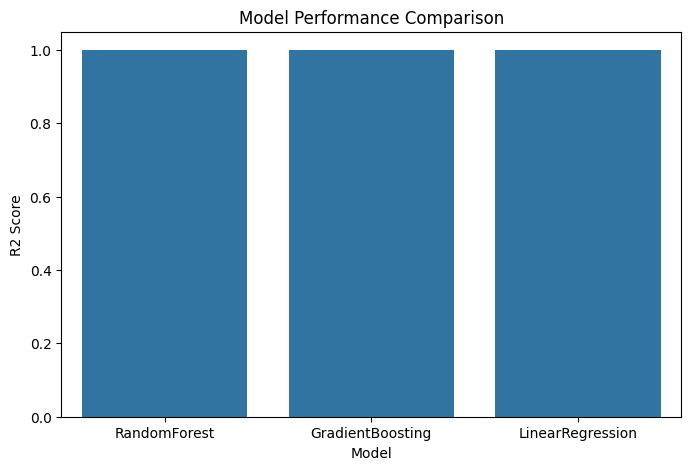

In [80]:
model_scores = {name: r2_score(y_test, model.predict(X_test_scaled)) for name, model in models.items()}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()))
plt.xlabel("Model")
plt.ylabel("R2 Score")
plt.title("Model Performance Comparison")
plt.show()